In [1]:
# import os
# import re
import numpy as np
import nltk
import pandas as pd
import collections
import matplotlib.pyplot as plt
import collections
import tensorflow as tf
import tensorflow_hub as hub
from google.colab import drive
drive.mount("/content/drive/")
df=pd.read_csv("drive/My Drive/NLP summer Internship/Cleanned_Complaints.csv")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# Show label distribution for the whole original dataset
df=df[df["Label"]!="Other financial service"]
df=df.dropna()
df.groupby("Label")["Complaint"].count()

Label
Bank account or service                                                          14885
Checking or savings account                                                      22432
Consumer Loan                                                                     9473
Credit card or prepaid card                                                      58842
Credit reporting, credit repair services, or other personal consumer reports    212844
Debt collection                                                                 116674
Money transfer, virtual currency, or money service                               10691
Mortgage                                                                         66255
Payday loan, title loan, or personal loan                                         9189
Student loan                                                                     26410
Vehicle loan or lease                                                             9486
Name: Complaint, dtype: int64

In [3]:
# df.groupby("Label")["Complaint"].count()

In [4]:
# Groupby company and count complaints
df.groupby("Company")["Label"].count().sort_values(ascending=False)[:20]

Company
EQUIFAX, INC.                             61364
Experian Information Solutions Inc.       56341
TRANSUNION INTERMEDIATE HOLDINGS, INC.    55056
CITIBANK, N.A.                            18255
WELLS FARGO & COMPANY                     17613
BANK OF AMERICA, NATIONAL ASSOCIATION     17287
JPMORGAN CHASE & CO.                      17176
CAPITAL ONE FINANCIAL CORPORATION         15009
Navient Solutions, LLC.                   14874
SYNCHRONY FINANCIAL                        9991
AMERICAN EXPRESS COMPANY                   6414
Ocwen Financial Corporation                5809
U.S. BANCORP                               5584
NATIONSTAR MORTGAGE                        5564
AES/PHEAA                                  5506
PORTFOLIO RECOVERY ASSOCIATES INC          5485
ENCORE CAPITAL GROUP INC.                  4615
DISCOVER BANK                              4480
Alliance Data Card Services                4221
Ditech Financial LLC                       3977
Name: Label, dtype: int64

In [5]:
# Prepare four vendor datasets and one Well's Fargo set
df_wells=df[df["Company"]=="WELLS FARGO & COMPANY"]
credit_unions=["TRANSUNION INTERMEDIATE HOLDINGS, INC."]
banks=["CITIBANK, N.A.","BANK OF AMERICA, NATIONAL ASSOCIATION","JPMORGAN CHASE & CO.","U.S. BANCORP"]
mortgages=["Ocwen Financial Corporation","NATIONSTAR MORTGAGE","Ditech Financial LLC","SELECT PORTFOLIO SERVICING, INC.",
           "Specialized Loan Servicing Holdings LLC","SYNCHRONY FINANCIAL"]
balanced=["Santander Consumer USA Holdings Inc.","Ocwen Financial Corporation","BANK OF AMERICA, NATIONAL ASSOCIATION",
          "JPMORGAN CHASE & CO.","U.S. BANCORP","PNC Bank N.A.","UNITED SERVICES AUTOMOBILE ASSOCIATION","SUNTRUST BANKS, INC."]
df_cu=df[df["Company"].isin(credit_unions)]
df_banks=df[df["Company"].isin(banks)]
df_mortgages=df[df["Company"].isin(mortgages)]
df_balanced=df[df["Company"].isin(balanced)]

In [6]:
# Check number of documents in each dataset
cu_complaint=df_cu["Complaint_reduced"]
banks_complaint=df_banks["Complaint_reduced"]
mortgages_complaint=df_mortgages["Complaint_reduced"]
balanced_complaint=df_balanced["Complaint_reduced"]
wells_complaint=df_wells["Complaint_reduced"]
print(cu_complaint.shape,banks_complaint.shape,mortgages_complaint.shape,balanced_complaint.shape,wells_complaint.shape)

(55056,) (58302,) (29905,) (57125,) (17613,)


In [7]:
# Helper function for tokenizers
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
def tokenizing(df,max_features):
  vectorizer=CountVectorizer(max_features=max_features)
  X= vectorizer.fit_transform(df)
  return vectorizer,X

### Part 1 Content Overlap scoring

#### 1.1 EDA

In [8]:
# Compare words overlapping first m frequent words for the whole dataset
# Number of word overlapping/m 
cu_wells=[]
mortgages_wells=[]
banks_wells=[]
balanced_wells=[]
for i in range(1,6):
  max_features=i*1000
  #vectorizer
  cu_vectorizer,X_cu=tokenizing(cu_complaint,max_features)
  banks_vectorizer,X_banks=tokenizing(banks_complaint,max_features)
  mortgages_vectorizer,X_mortgages=tokenizing(mortgages_complaint,max_features)
  balanced_vectorizer,X_balanced=tokenizing(balanced_complaint,max_features)
  wells_vectorizer,X_wells=tokenizing(wells_complaint,max_features)
  #get frequent words
  cu_fq_words=cu_vectorizer.get_feature_names()
  banks_fq_words=banks_vectorizer.get_feature_names()
  mortgages_fq_words=mortgages_vectorizer.get_feature_names()
  balanced_fq_words=balanced_vectorizer.get_feature_names()
  wells_fq_words=wells_vectorizer.get_feature_names()
  # calculate overlap percentage
  overlap_cu_wells=len(set(cu_fq_words)&set(wells_fq_words))/max_features
  overlap_banks_wells=len(set(banks_fq_words)&set(wells_fq_words))/max_features
  overlap_mortgages_wells=len(set(mortgages_fq_words)&set(wells_fq_words))/max_features
  overlap_balanced_wells=len(set(balanced_fq_words)&set(wells_fq_words))/max_features
  # Append percentages to the list
  cu_wells.append(overlap_cu_wells)
  mortgages_wells.append(overlap_mortgages_wells)
  banks_wells.append(overlap_banks_wells)
  balanced_wells.append(overlap_balanced_wells)

# Print degree of overlapping
print(f'cu-wells-overlap',cu_wells)
print(f'mortgages-wells-overlap',mortgages_wells)
print(f'banks-wells-overlap',banks_wells)
print(f'balanced-wells-overlap',balanced_wells)

cu-wells-overlap [0.769, 0.8195, 0.827, 0.81325, 0.7932]
mortgages-wells-overlap [0.89, 0.897, 0.8963333333333333, 0.88025, 0.8622]
banks-wells-overlap [0.908, 0.9205, 0.9073333333333333, 0.899, 0.8858]
balanced-wells-overlap [0.928, 0.9335, 0.9193333333333333, 0.9055, 0.8904]


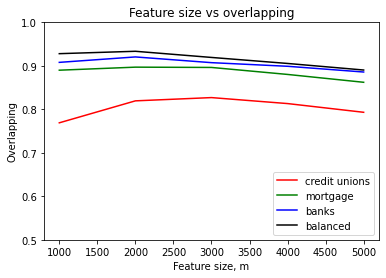

In [9]:
# Plot degree of overlapping for different size m
x=[1000,2000,3000,4000,5000]
plt.plot(x,cu_wells,color="red",label="credit unions")
plt.plot(x,mortgages_wells,color="green",label="mortgage")
plt.plot(x,banks_wells,color="blue",label="banks")
plt.plot(x,balanced_wells,color="black",label="balanced")
plt.legend(loc="lower right")
plt.xlabel("Feature size, m")
plt.ylabel("Overlapping")
plt.title("Feature size vs overlapping")
plt.ylim(0.5, 1)
plt.show()

#### 1.2 Determining M

In [10]:
# Count all vocaburary frequency in all dataset, set max_features to None
cu_vectorizer,X_cu=tokenizing(cu_complaint,None)
banks_vectorizer,X_banks=tokenizing(banks_complaint,None)
mortgages_vectorizer,X_mortgages=tokenizing(mortgages_complaint,None)
balanced_vectorizer,X_balanced=tokenizing(balanced_complaint,None)
wells_vectorizer,X_wells=tokenizing(wells_complaint,None)
cu_freq=X_cu.sum(axis=0)
banks_freq=X_banks.sum(axis=0)
mortgages_freq=X_mortgages.sum(axis=0)
balanced_freq=X_balanced.sum(axis=0)
wells_freq=X_wells.sum(axis=0)
cu_freq=np.sort(np.squeeze(np.asarray(cu_freq)))[::-1]/cu_freq.sum()
banks_freq=np.sort(np.squeeze(np.asarray(banks_freq)))[::-1]/banks_freq.sum()
mortgages_freq=np.sort(np.squeeze(np.asarray(mortgages_freq)))[::-1]/mortgages_freq.sum()
balanced_freq=np.sort(np.squeeze(np.asarray(balanced_freq)))[::-1]/balanced_freq.sum()
wells_freq=np.sort(np.squeeze(np.asarray(wells_freq)))[::-1]/wells_freq.sum()

In [11]:
# Helper function for the plot
# Argument:
# Title: Str
# freq_array: np.array, shape=(#tokens,)
# bin_size: int, such as 1000,2000
# Threshold: float, such as 0.9, function will print first size when hit threshold
def m_vs_token(title,freq_array,bin_size,threshold):
  total_size=freq_array.shape[0]
  axis=[]
  total_freq=[]
  for i in range(bin_size,total_size,bin_size):
    axis.append(i)
    temp=freq_array[:i].sum()
    total_freq.append(temp)
  k=0
  while total_freq[k]<threshold:
    k+=1
  print(axis[k])
  plt.figure(figsize=(10,5))
  plt.title(title,size=14)
  plt.xlabel("m size",size=14)
  plt.ylabel("token coverage",size=14)
  plt.plot([k], [threshold], 'ro')
  plt.plot(axis,total_freq)
  plt.show()

In [12]:
coverage=0.9

793


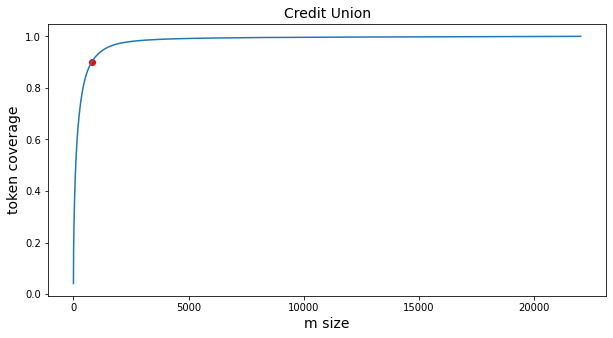

In [13]:
m_vs_token("Credit Union",cu_freq,1,coverage)

1150


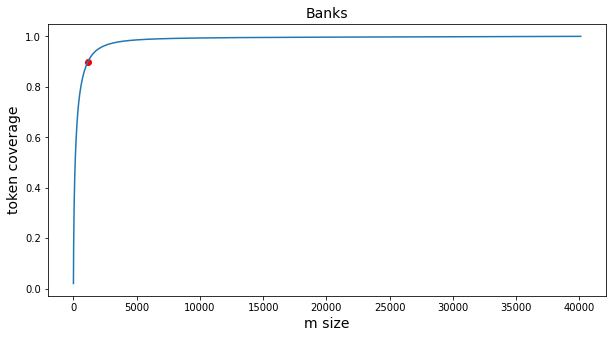

In [14]:
m_vs_token("Banks",banks_freq,1,coverage)

1138


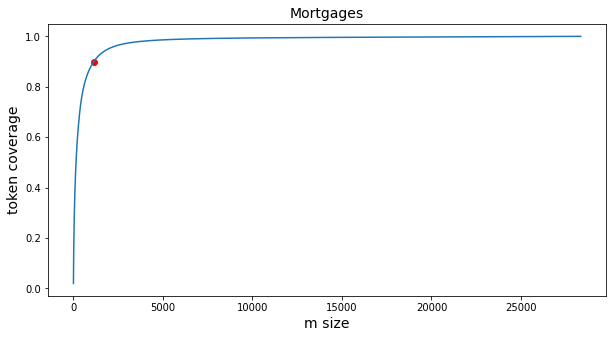

In [15]:
m_vs_token("Mortgages",mortgages_freq,1,coverage)

1189


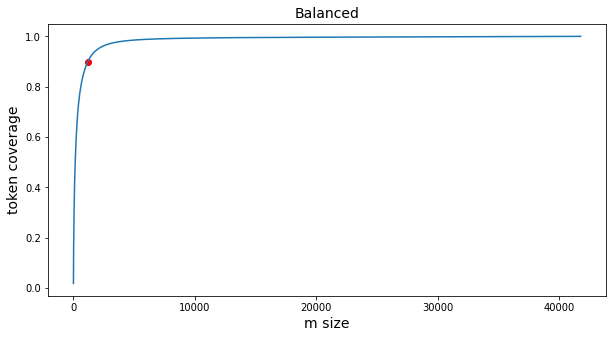

In [16]:
m_vs_token("Balanced",balanced_freq,1,coverage)

1151


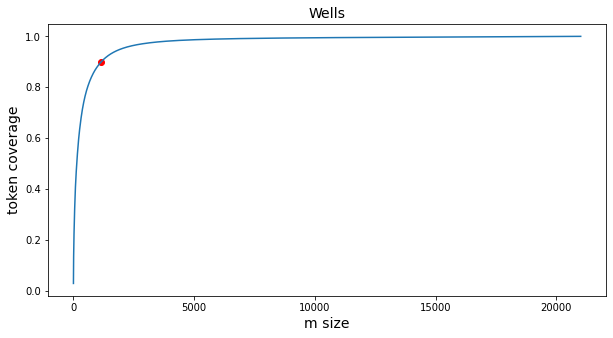

In [17]:
m_vs_token("Wells",wells_freq,1,coverage)


#### 1.3 Calculating scores distribution

In [18]:
Wells_M_size=None
#Tokenizer
cu_vectorizer,X_cu=tokenizing(cu_complaint,793)
banks_vectorizer,X_banks=tokenizing(banks_complaint,1150)
mortgages_vectorizer,X_mortgages=tokenizing(mortgages_complaint,1138)
balanced_vectorizer,X_balanced=tokenizing(balanced_complaint,1152)
wells_vectorizer,X_wells=tokenizing(wells_complaint,Wells_M_size)

cu_fq_words=cu_vectorizer.get_feature_names()
banks_fq_words=banks_vectorizer.get_feature_names()
mortgages_fq_words=mortgages_vectorizer.get_feature_names()
balanced_fq_words=balanced_vectorizer.get_feature_names()
wells_fq_words=wells_vectorizer.get_feature_names()

#calculating original sentence word count
smoothing=0.001
wells_words_count=X_wells.toarray().sum(axis=1)+smoothing

#finding overlaping words
wells_cu_overlap=set(cu_fq_words)&set(wells_fq_words)
wells_banks_overlap=set(banks_fq_words)&set(wells_fq_words)
wells_mortgages_overlap=set(mortgages_fq_words)&set(wells_fq_words)
wells_balanced_overlap=set(balanced_fq_words)&set(wells_fq_words)

#searching overlaping index
wells_cu_overlap_idx=[wells_vectorizer.vocabulary_[i] for i in wells_cu_overlap]
wells_banks_overlap_idx=[wells_vectorizer.vocabulary_[i] for i in wells_banks_overlap]
wells_mortgages_overlap_idx=[wells_vectorizer.vocabulary_[i] for i in wells_mortgages_overlap]
wells_balanced_overlap_idx=[wells_vectorizer.vocabulary_[i] for i in wells_balanced_overlap]

#calculating sentence ovelapping word count
wells_cu_overlap_word_count=X_wells[:,wells_cu_overlap_idx].toarray().sum(axis=1)
wells_banks_overlap_word_count=X_wells[:,wells_banks_overlap_idx].toarray().sum(axis=1)
wells_mortgages_overlap_word_count=X_wells[:,wells_mortgages_overlap_idx].toarray().sum(axis=1)
wells_balanced_overlap_word_count=X_wells[:,wells_balanced_overlap_idx].toarray().sum(axis=1)

#dividing sentence word count to get the score for each document
wells_cu_sentence_score=wells_cu_overlap_word_count/wells_words_count
wells_banks_sentence_score=wells_banks_overlap_word_count/wells_words_count
wells_mortgages_sentence_score=wells_mortgages_overlap_word_count/wells_words_count
wells_balanced_sentence_score=wells_balanced_overlap_word_count/wells_words_count


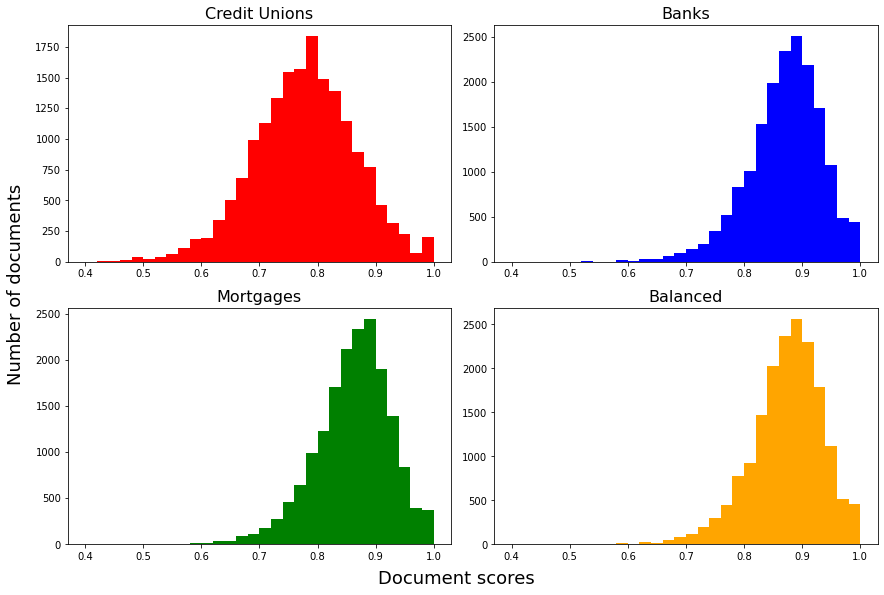

In [19]:
#plotting
fig, ax = plt.subplots(2, 2,figsize=(12, 8))

ax[0,0].set_title("Credit Unions",fontsize=16)
ax[0,1].set_title("Banks",fontsize=16)
ax[1,0].set_title("Mortgages",fontsize=16)
ax[1,1].set_title("Balanced",fontsize=16)

ax[0,0].hist(wells_cu_sentence_score,bins=30,range=(0.4,1),color="red")
ax[0,1].hist(wells_banks_sentence_score,bins=30,range=(0.4,1),color="blue")
ax[1,0].hist(wells_mortgages_sentence_score,bins=30,range=(0.4,1),color="green")
ax[1,1].hist(wells_balanced_sentence_score,bins=30,range=(0.4,1),color="orange")

fig.text(0.5, -0.02, 'Document scores', ha='center',size=18)
fig.text(-0.02, 0.5, 'Number of documents', va='center', rotation='vertical',size=18)

fig.tight_layout()
plt.show()

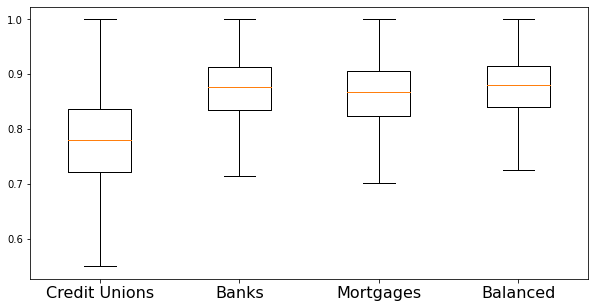

In [20]:
plt.figure(figsize=(10,5))
box_plot = [wells_cu_sentence_score, wells_banks_sentence_score, wells_mortgages_sentence_score, wells_balanced_sentence_score]
plt.boxplot(box_plot,showfliers=False)
plt.xticks(np.arange(1,5),("Credit Unions","Banks","Mortgages","Balanced"),size=16)
plt.show()

#### 1.4 Setting threshold

In [21]:
(np.mean(wells_cu_sentence_score)+np.mean(wells_banks_sentence_score)+np.mean(wells_mortgages_sentence_score)+np.mean(wells_balanced_sentence_score))/4

0.8456278197352383

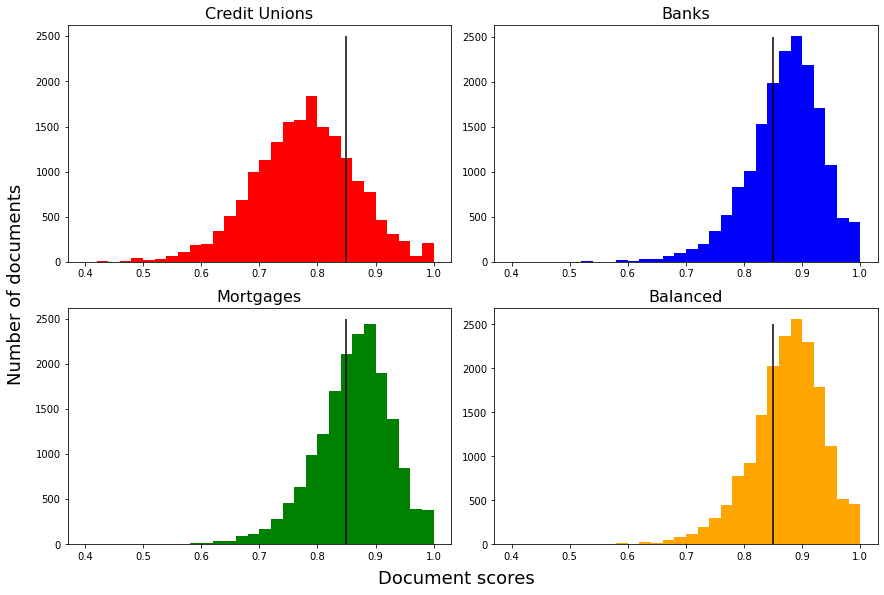

In [22]:
Threshold1=0.85
#plotting
fig, ax = plt.subplots(2, 2,figsize=(12, 8))

ax[0,0].set_title("Credit Unions",fontsize=16)
ax[0,1].set_title("Banks",fontsize=16)
ax[1,0].set_title("Mortgages",fontsize=16)
ax[1,1].set_title("Balanced",fontsize=16)

ax[0,0].hist(wells_cu_sentence_score,bins=30,range=(0.4,1),color="red")
ax[0,1].hist(wells_banks_sentence_score,bins=30,range=(0.4,1),color="blue")
ax[1,0].hist(wells_mortgages_sentence_score,bins=30,range=(0.4,1),color="green")
ax[1,1].hist(wells_balanced_sentence_score,bins=30,range=(0.4,1),color="orange")
ax[0,0].vlines(x=Threshold1,ymin=0,ymax=2500)
ax[0,1].vlines(x=Threshold1,ymin=0,ymax=2500)
ax[1,0].vlines(x=Threshold1,ymin=0,ymax=2500)
ax[1,1].vlines(x=Threshold1,ymin=0,ymax=2500)

fig.text(0.5, -0.02, 'Document scores', ha='center',size=18)
fig.text(-0.02, 0.5, 'Number of documents', va='center', rotation='vertical',size=18)

fig.tight_layout()
plt.show()

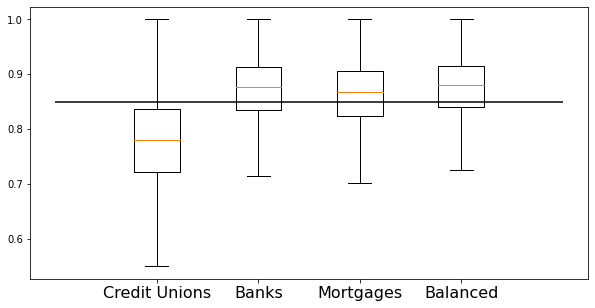

In [23]:
plt.figure(figsize=(10,5))
box_plot = [wells_cu_sentence_score, wells_banks_sentence_score, wells_mortgages_sentence_score, wells_balanced_sentence_score]
plt.boxplot(box_plot,showfliers=False)
plt.hlines(y=0.85,xmin=0,xmax=5)
plt.xticks(np.arange(1,5),("Credit Unions","Banks","Mortgages","Balanced"),size=16)
plt.show()

#### 1.5 Final scores

In [24]:
print(f'Credit Unions vendor set score',np.sum(wells_cu_sentence_score>Threshold1)/wells_cu_sentence_score.shape[0])
print(f'Banks vendor set score',np.sum(wells_banks_sentence_score>Threshold1)/wells_banks_sentence_score.shape[0])
print(f'Mortgages vendor set score',np.sum(wells_mortgages_sentence_score>Threshold1)/wells_mortgages_sentence_score.shape[0])
print(f'Balanced vendor set score',np.sum(wells_balanced_sentence_score>Threshold1)/wells_balanced_sentence_score.shape[0])

Credit Unions vendor set score 0.19638903082950093
Banks vendor set score 0.6691080451938909
Mortgages vendor set score 0.6126156815988191
Balanced vendor set score 0.6879577584738545


### Part 2 Semantic Meaning Similarity Approach

#### 2.1 Embedding use USE

In [25]:
# Load pretrained model - google universal sentence encoder
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
model = hub.load(module_url)
def embed(input):
  return model(input)

In [26]:
# Coding block to calculate pairwise similarity matrix
# This will take 10 minutes to embed and require around 15G memory
print("now embedding wells dataset")
# Embedding wells dataset
wells_embed=np.array(embed(wells_complaint))

print("now embedding cu dataset")
# Embedding cu dataset
cu_embed1=embed(cu_complaint[0:15000])
cu_embed2=embed(cu_complaint[15000:30000])
cu_embed3=embed(cu_complaint[30000:45000])
cu_embed4=embed(cu_complaint[45000:])
cu_embed=np.concatenate((cu_embed1,cu_embed2,cu_embed3,cu_embed4),axis=0)
del(cu_embed1)
del(cu_embed2)
del(cu_embed3)
del(cu_embed4)
#pairwise similarity
cu_wells_matrix=np.dot(wells_embed,tf.transpose(cu_embed))
#delete embedding and keep similarity matrix to save memory
del(cu_embed)

print("now embedding mortgages dataset")
# Embedding mortgages dataset
mortgages_embed1=embed(mortgages_complaint[0:15000])
mortgages_embed2=embed(mortgages_complaint[15000:])
mortgages_embed=np.concatenate((mortgages_embed1,mortgages_embed2),axis=0)
del(mortgages_embed1)
del(mortgages_embed2)
#pairwise similarity
mortgages_wells_matrix=np.dot(wells_embed,tf.transpose(mortgages_embed))
#delete embedding and keep similarity matrix to save memory
del(mortgages_embed)

print("now embedding banks dataset")
# Embedding banks dataset
banks_embed1=embed(banks_complaint[0:15000])
banks_embed2=embed(banks_complaint[15000:30000])
banks_embed3=embed(banks_complaint[30000:45000])
banks_embed4=embed(banks_complaint[45000:])
banks_embed=np.concatenate((banks_embed1,banks_embed2,banks_embed3,banks_embed4),axis=0)
del(banks_embed1)
del(banks_embed2)
del(banks_embed3)
del(banks_embed4)
banks_wells_matrix=np.dot(wells_embed,tf.transpose(banks_embed))
del(banks_embed)

print("now embedding balanced dataset")
# Embedding banks dataset
balanced_embed1=embed(balanced_complaint[0:15000])
balanced_embed2=embed(balanced_complaint[15000:30000])
balanced_embed3=embed(balanced_complaint[30000:45000])
balanced_embed4=embed(balanced_complaint[45000:])
balanced_embed=np.concatenate((balanced_embed1,balanced_embed2,balanced_embed3,balanced_embed4),axis=0)
del(balanced_embed1)
del(balanced_embed2)
del(balanced_embed3)
del(balanced_embed4)
balanced_wells_matrix=np.dot(wells_embed,tf.transpose(balanced_embed))
del(balanced_embed)
# Check pairwise similarity matrix shapes
print(cu_wells_matrix.shape,mortgages_wells_matrix.shape,banks_wells_matrix.shape,balanced_wells_matrix.shape)

now embedding wells dataset
now embedding cu dataset
now embedding mortgages dataset
now embedding banks dataset
now embedding balanced dataset
(17613, 55056) (17613, 29905) (17613, 58302) (17613, 57125)


#### Calculating cosine similarity scores

In [27]:
import math
n_similarity=5
# Compute pairwise cosine similarity and find largest n scores' average
cu_wells_top_similarity=np.sum(np.partition(cu_wells_matrix, -n_similarity)[:,-n_similarity:],axis=1)/n_similarity
mortgages_wells_top_similarity=np.sum(np.partition(mortgages_wells_matrix, -n_similarity)[:,-n_similarity:],axis=1)/n_similarity
banks_wells_top_similarity=np.sum(np.partition(banks_wells_matrix, -n_similarity)[:,-n_similarity:],axis=1)/n_similarity
balanced_wells_top_similarity=np.sum(np.partition(balanced_wells_matrix, -n_similarity)[:,-n_similarity:],axis=1)/n_similarity
# Check shape, the shape should be (wells_fargo.shape[0],)
print(cu_wells_top_similarity.shape,mortgages_wells_top_similarity.shape,banks_wells_top_similarity.shape,balanced_wells_top_similarity.shape)

(17613,) (17613,) (17613,) (17613,)


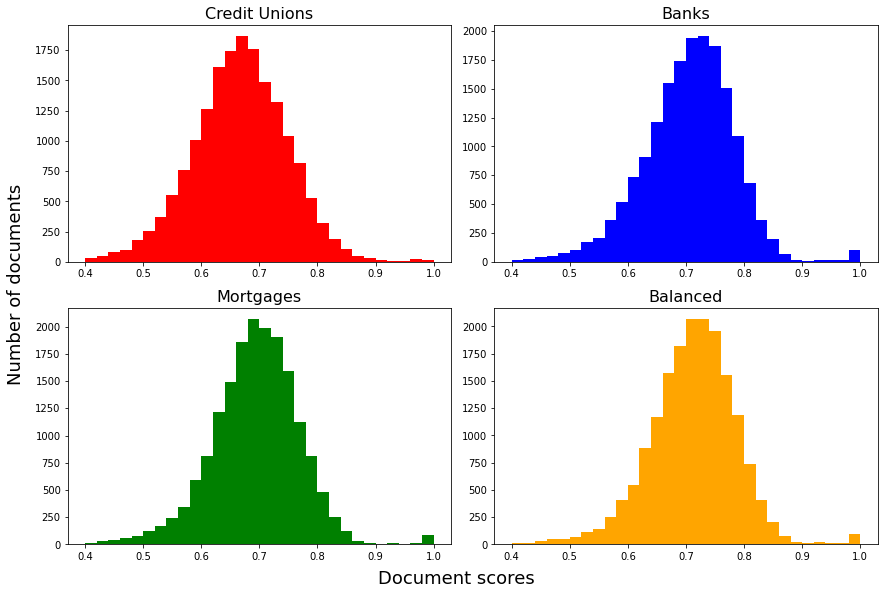

In [28]:
# Plot result distribution
fig, ax = plt.subplots(2, 2,figsize=(12, 8))

ax[0,0].set_title("Credit Unions",fontsize=16)
ax[0,1].set_title("Banks",fontsize=16)
ax[1,0].set_title("Mortgages",fontsize=16)
ax[1,1].set_title("Balanced",fontsize=16)

ax[0,0].hist(cu_wells_top_similarity,bins=30,range=(0.4,1),color="red")
ax[0,1].hist(banks_wells_top_similarity,bins=30,range=(0.4,1),color="blue")
ax[1,0].hist(mortgages_wells_top_similarity,bins=30,range=(0.4,1),color="green")
ax[1,1].hist(balanced_wells_top_similarity,bins=30,range=(0.4,1),color="orange")

fig.text(0.5, -0.02, 'Document scores', ha='center',size=18)
fig.text(-0.02, 0.5, 'Number of documents', va='center', rotation='vertical',size=18)

fig.tight_layout()
plt.show()

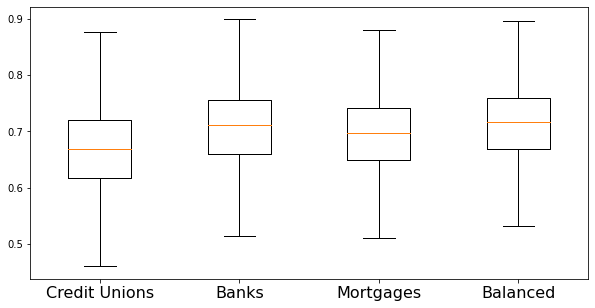

In [29]:
plt.figure(figsize=(10,5))
box_plot = [cu_wells_top_similarity, banks_wells_top_similarity, mortgages_wells_top_similarity, balanced_wells_top_similarity]
plt.boxplot(box_plot,showfliers=False)
plt.xticks(np.arange(1,5),("Credit Unions","Banks","Mortgages","Balanced"),size=16)
plt.show()

In [30]:
(np.mean(cu_wells_top_similarity)+np.mean(banks_wells_top_similarity)+np.mean(mortgages_wells_top_similarity)+np.mean(balanced_wells_top_similarity))/4

0.6943039894104004

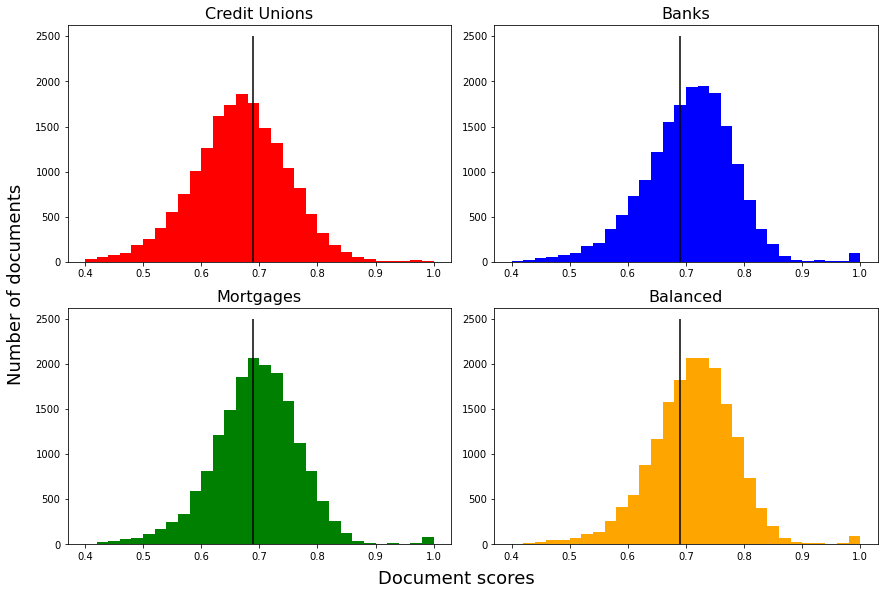

In [31]:
Threshold2=0.69
# Plot result distribution
fig, ax = plt.subplots(2, 2,figsize=(12, 8))

ax[0,0].set_title("Credit Unions",fontsize=16)
ax[0,1].set_title("Banks",fontsize=16)
ax[1,0].set_title("Mortgages",fontsize=16)
ax[1,1].set_title("Balanced",fontsize=16)

ax[0,0].hist(cu_wells_top_similarity,bins=30,range=(0.4,1),color="red")
ax[0,1].hist(banks_wells_top_similarity,bins=30,range=(0.4,1),color="blue")
ax[1,0].hist(mortgages_wells_top_similarity,bins=30,range=(0.4,1),color="green")
ax[1,1].hist(balanced_wells_top_similarity,bins=30,range=(0.4,1),color="orange")
ax[0,0].vlines(x=Threshold2,ymin=0,ymax=2500)
ax[0,1].vlines(x=Threshold2,ymin=0,ymax=2500)
ax[1,0].vlines(x=Threshold2,ymin=0,ymax=2500)
ax[1,1].vlines(x=Threshold2,ymin=0,ymax=2500)

fig.text(0.5, -0.02, 'Document scores', ha='center',size=18)
fig.text(-0.02, 0.5, 'Number of documents', va='center', rotation='vertical',size=18)

fig.tight_layout()
plt.show()

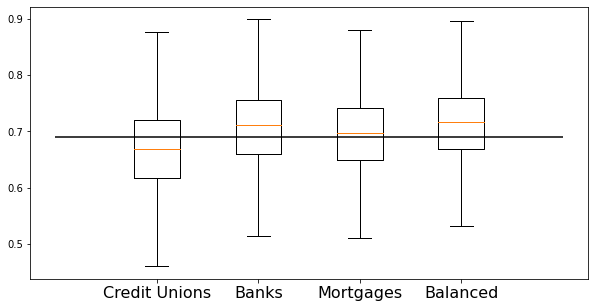

In [32]:
plt.figure(figsize=(10,5))
box_plot = [cu_wells_top_similarity, banks_wells_top_similarity, mortgages_wells_top_similarity, balanced_wells_top_similarity]
plt.boxplot(box_plot,showfliers=False)
plt.hlines(y=0.69,xmin=0,xmax=5)
plt.xticks(np.arange(1,5),("Credit Unions","Banks","Mortgages","Balanced"),size=16)
plt.show()

In [33]:
print(np.sum(cu_wells_top_similarity>0.69)/cu_wells_top_similarity.shape[0])
print(np.sum(banks_wells_top_similarity>0.69)/banks_wells_top_similarity.shape[0])
print(np.sum(mortgages_wells_top_similarity>0.69)/mortgages_wells_top_similarity.shape[0])
print(np.sum(balanced_wells_top_similarity>0.69)/balanced_wells_top_similarity.shape[0])

0.38664622721853176
0.6110827229887015
0.5389768920683586
0.6448078124112872
